In [41]:
import math
import random
import numpy as np
from datetime import datetime
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
config = tf.compat.v1.ConfigProto()
tf.config.list_physical_devices('GPU')

config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [42]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

In [43]:
import os
train_dir = f"{os.getcwd()}\\..\\data\\tr"
batch_size = 32
time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

In [44]:
def labeler(example, index):
    return example, tf.cast(index, tf.int64)

In [45]:
FILE_NAMES = ['combinedneg.txt', 'combinedneut2.txt', 'combinedpos.txt']
labeled_data_sets = []
# Give labels to the data, 0 for negatives, 1 for neutrals, 2 for positives.
for i, file_name in enumerate(FILE_NAMES):
    lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\{file_name}")
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_data_sets.append(labeled_dataset)

In [46]:
BUFFER_SIZE = 50000

In [47]:
# concatenate all labeled datasets into one and shuffle
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

In [48]:
DATASET_SIZE = [i for i,_ in enumerate(all_labeled_data)][-1] + 1
BATCH_SIZE = 32
VALIDATION_SIZE = math.ceil(DATASET_SIZE * 0.1)
VOCAB_SIZE = 45000

In [49]:
print('Labels are 0 = negative, 1 = neutral, 2 = positive.\n')
for text, label in all_labeled_data.take(1):
    print("Sentence: ", text.numpy())
    print("Label:", label.numpy())

Labels are 0 = negative, 1 = neutral, 2 = positive.

Sentence:  b'pyyhi ensin leukasi, juoppolalli, ja sitten p\xc3\xb6yt\xc3\xa4!'
Label: 0


In [50]:
train_dataset = all_labeled_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = all_labeled_data.take(VALIDATION_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [51]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])
encoder = TextVectorization()
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())
print(len(vocab), vocab[:20])
encoded_example = encoder(example)[:3].numpy()
print(encoded_example)
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

texts:  [b'emakothan ovat sateenkaarimets\xc3\xa4st\xc3\xa4jille inhotus.'
 b'eik\xc3\xb6s ole olemassa jokin logi-tiedosto, miss\xc3\xa4 n\xc3\xa4kyv\xc3\xa4t n\xc3\xa4m\xc3\xa4 k\xc3\xa4ynnistyksen yhteydess\xc3\xa4 tapahtuvat toiminnot ja sielt\xc3\xa4 voi poistaa jonkun rivin?'
 b'olen toki puolueellinen, mutta h\xc3\xa4n on mielest\xc3\xa4ni sangen suloinen neiti.']

labels:  [0 1 2]
54570 ['' '[UNK]' 'on' 'ja' 'ei' 'se' 'että' 'ole' 'en' 'mutta' 'kun' 'niin'
 'jos' 'hän' 'olen' 'oli' 'mitä' 'voi' 'nyt' 'kuin']
[[50522    25 27679 46435     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [  857     7   439   572 38779   136  4553   191 40319  1191  4319 23238
      3   399    17  3199   329 11829     0     0     0]
 [   14   298 12201     9    13     2   366  7438  3612   901     0     0
      0     0     0     0     0     0     0     0     0]]
Original:  b'emakothan ovat sateenkaarimets\xc3\xa4st\xc3\xa4jille inhotus.'
Round-t

In [52]:
import pickle
with open("..\\data\\others\\vocab2.pickle", "wb") as output_file:
    pickle.dump(vocab, output_file)

In [53]:
def create_model(num_labels):
    model_layers = tf.keras.Sequential([
        encoder,
        layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=32, embeddings_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), mask_zero=False),
        layers.Bidirectional(layers.LSTM(128, dropout=0.1, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(64, dropout=0.1)),
        layers.Dropout(0.10),
        layers.Dense(64, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation='relu'),
        layers.Dropout(0.10),
        layers.Dense(num_labels),
        layers.Activation('softmax')])
    return model_layers

In [54]:
model = create_model(num_labels=3)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=1)
model.compile(
    optimizer=optimizers.Adamax(0.005),
    loss=losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=test_dataset, callbacks=[early_stop], epochs=30)
model.summary()

Epoch 1/30
979/979 [==============================] - 33s 27ms/step - loss: 0.9244 - accuracy: 0.5687 - val_loss: 0.8435 - val_accuracy: 0.6309
Epoch 2/30
979/979 [==============================] - 25s 26ms/step - loss: 0.7510 - accuracy: 0.7011 - val_loss: 0.7757 - val_accuracy: 0.7004
Epoch 3/30
979/979 [==============================] - 27s 27ms/step - loss: 0.5741 - accuracy: 0.8070 - val_loss: 0.7538 - val_accuracy: 0.7150
Epoch 4/30
979/979 [==============================] - 26s 26ms/step - loss: 0.4234 - accuracy: 0.8765 - val_loss: 0.8151 - val_accuracy: 0.7219
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 32)          1746240   
_________________________________________________________________
bidire

In [55]:
model.save(f'model/rnn_{time}')
# model.save(f'model/rnn_{time}.h5')

INFO:tensorflow:Assets written to: model/rnn_18-11-2021_14-29-46\assets


INFO:tensorflow:Assets written to: model/rnn_18-11-2021_14-29-46\assets


In [56]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

109/109 [==============================] - 2s 15ms/step - loss: 0.8151 - accuracy: 0.7219
Test Loss: 0.8151142001152039
Test Accuracy: 0.7219190001487732


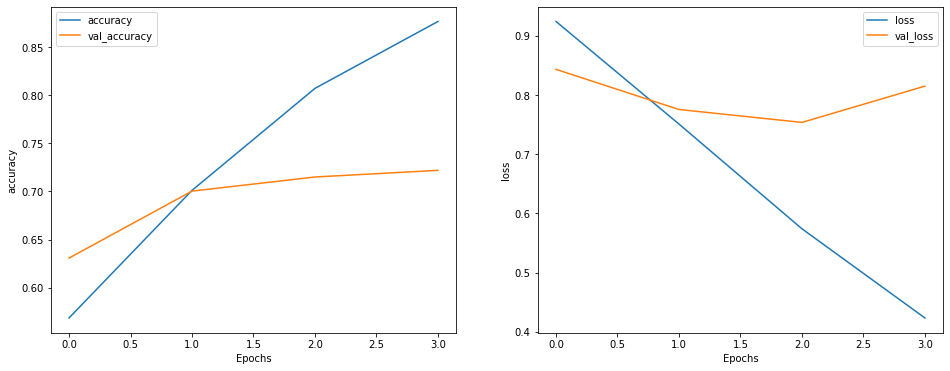

In [57]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [58]:
modelpath = f"model/rnn_{time}"
import_model = tf.keras.models.load_model(modelpath)
import_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 32)          1746240   
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 256)         164864    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

In [59]:
n = 5
inputs = []
with open(f"D:\\Work\\Data\\s24_2001_sentences_shuffled_slice.txt", 'r', encoding='utf-8') as f:
    lines = f.readlines()
    random.shuffle(lines)
    for line in lines:
        inputs.append(line.strip('\n'))
inputs = np.array(inputs[:n])
print(inputs[:n])

['Kuten sanot, jumaliin voi vain uskoa. '
 'Poikkeilen muiden vaimoilla ja avoilla..ja he minulla. '
 'Joku on taas petetty. '
 'GM farmiin South West Trade myy tankkia 1800 mk. Sedanista en tiedä, mut soita 036161881. '
 'Mulle nyt on ihan sama onko joku homo tai lesbo, en sillaa niitä mitenkään vastusta ja mulle on ihan sama jos ne virallistaa suhteensa, mutta sit mun mielestä menee liian pitkälle jos sitä sanotaan "avioliitoks".. ']


In [60]:
def make_prediction(inps):
    predicted_scores = import_model.predict(np.array(inps))
    predicted_labels = tf.argmax(predicted_scores, axis=1)
    lab, pred = '', ''
    labs, preds = [], []
    for i, (inp, label) in enumerate(zip(inputs, predicted_labels)):
        pred = (', '.join(f'{q:.5f}' for q in predicted_scores[i]))
        lab = label.numpy()
        print(f"Sentence: {inp}")
        print(f"Predicted label: {lab}")
        print(f"Predicted probs: {pred}\n")
        labs.append(lab)
        preds.append(pred)
    return labs, preds

print(np.array(inputs), '\n\n', make_prediction(inputs))

Sentence: Kuten sanot, jumaliin voi vain uskoa. 
Predicted label: 1
Predicted probs: 0.22955, 0.70311, 0.06734

Sentence: Poikkeilen muiden vaimoilla ja avoilla..ja he minulla. 
Predicted label: 0
Predicted probs: 0.70347, 0.16232, 0.13421

Sentence: Joku on taas petetty. 
Predicted label: 0
Predicted probs: 0.88628, 0.08437, 0.02935

Sentence: GM farmiin South West Trade myy tankkia 1800 mk. Sedanista en tiedä, mut soita 036161881. 
Predicted label: 1
Predicted probs: 0.00028, 0.98752, 0.01220

Sentence: Mulle nyt on ihan sama onko joku homo tai lesbo, en sillaa niitä mitenkään vastusta ja mulle on ihan sama jos ne virallistaa suhteensa, mutta sit mun mielestä menee liian pitkälle jos sitä sanotaan "avioliitoks".. 
Predicted label: 2
Predicted probs: 0.00565, 0.00473, 0.98962

['Kuten sanot, jumaliin voi vain uskoa. '
 'Poikkeilen muiden vaimoilla ja avoilla..ja he minulla. '
 'Joku on taas petetty. '
 'GM farmiin South West Trade myy tankkia 1800 mk. Sedanista en tiedä, mut soita 036